# Nearest Neighbours

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
crimes_df = pd.read_csv("crimes_processed.csv")
meuse_df = pd.read_csv("meuse_processed.csv")

In [3]:
meuse_df

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460


In [4]:
crimes_df

,Latitude,Longitude,n,location_id
0,41.644590,-87.615880,1,1
1,41.647037,-87.616647,1,2
2,41.647039,-87.616098,2,3
3,41.647180,-87.544241,1,4
4,41.647716,-87.542811,1,5
...,...,...,...,...
25449,42.022526,-87.672401,1,25450
25450,42.022529,-87.666324,1,25451
25451,42.022535,-87.673398,2,25452
25452,42.022536,-87.673711,1,25453


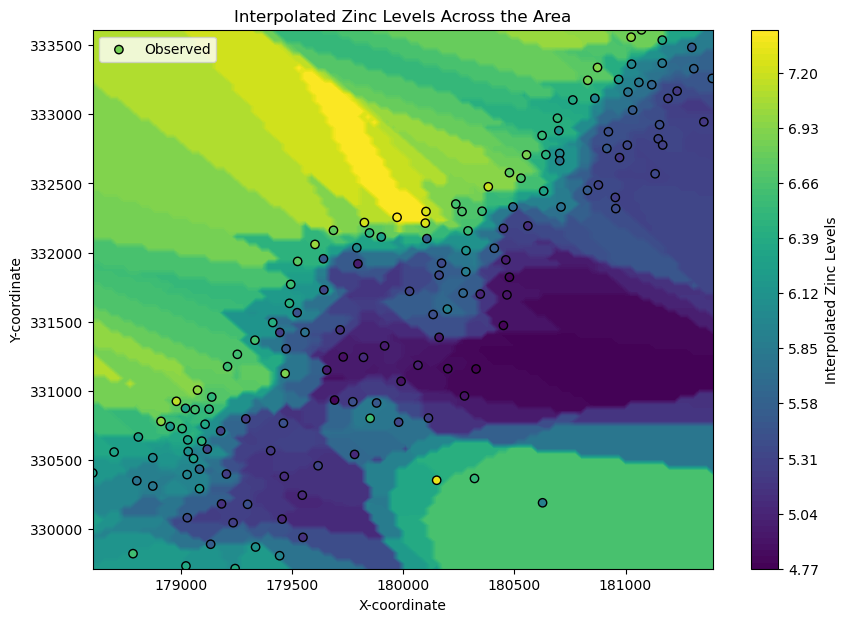

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Columns for observed and unobserved locations, and observed values
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'

# Convert columns to numpy arrays
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Number of nearest neighbors to consider
n_neighbors = 3

# Fit the nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(observed_locations)

# Create a dense grid of points over the entire area
x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values based on the nearest neighbors
# Here, we simply take the mean of the neighbors' values as the interpolated value
interpolated_values = np.mean(observed_values[indices], axis=1)

# Reshape for visualization
z_grid = interpolated_values.reshape(x_grid.shape)

# Plotting for visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area')
plt.show()


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store true values and predictions
true_values = []
predictions = []

for loo_idx in range(observed_locations.shape[0]):
    # Leave-one-out: use one sample as test set and the rest as training set
    train_idx = np.arange(observed_locations.shape[0]) != loo_idx
    test_idx = np.arange(observed_locations.shape[0]) == loo_idx
    
    train_locations = observed_locations[train_idx]
    train_values = observed_values[train_idx]
    test_location = observed_locations[test_idx].reshape(1, -1)
    test_value = observed_values[test_idx]
    
    # Re-fit the nearest neighbors model using only the training data
    nn_model.fit(train_locations)
    
    # Find the n nearest neighbors of the test location
    distances, indices = nn_model.kneighbors(test_location)
    
    # Predict the value for the test location by averaging its neighbors' values
    predicted_value = np.mean(train_values[indices])
    
    # Store the true value and the prediction
    true_values.append(test_value[0])  # test_value is a single-element array
    predictions.append(predicted_value)

# Convert lists to arrays for performance metric calculations
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate MAE and RMSE
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 0.33
Root Mean Squared Error (RMSE): 0.44


Mean Absolute Error (MAE): 0.33
Root Mean Squared Error (RMSE): 0.44


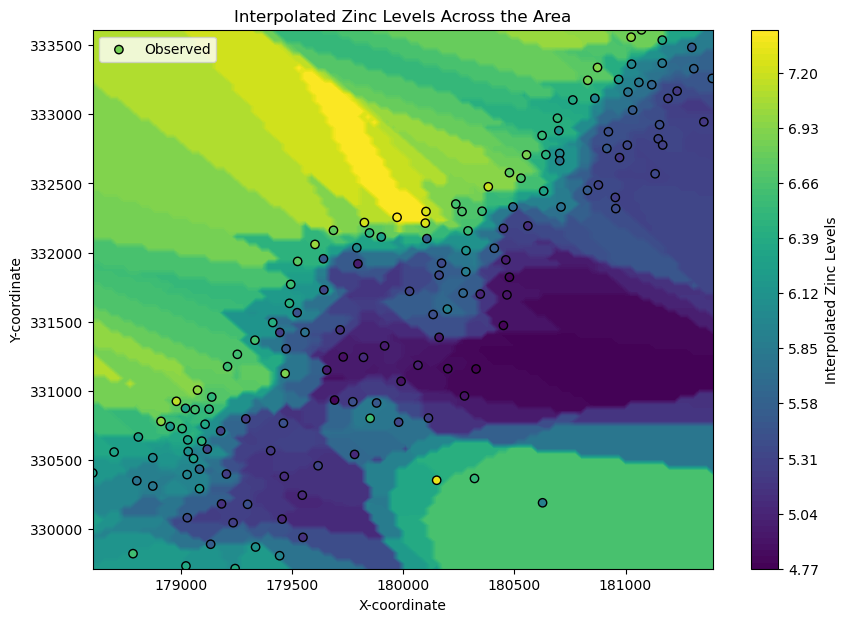

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import NearestNeighbors

# Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Number of nearest neighbors to consider
n_neighbors = 3

# Initialize NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)

# Initialize lists for LOOCV
true_values = []
predictions = []

# Perform LOOCV for evaluating model performance
for loo_idx in range(observed_locations.shape[0]):
    
    # Split data into training and testing sets
    # Train on N-1 data points
    train_idx = np.arange(observed_locations.shape[0]) != loo_idx
    # Test on 1 data point specfically the one with index = loo_idx
    test_idx = np.arange(observed_locations.shape[0]) == loo_idx
    
    train_locations = observed_locations[train_idx]
    train_values = observed_values[train_idx]
    test_location = observed_locations[test_idx].reshape(1, -1)
    test_value = observed_values[test_idx]
    
    # Fit the model on the training set
    nn_model.fit(train_locations)
    
    # Find the n nearest neighbors of the test location
    distances, indices = nn_model.kneighbors(test_location)
    
    # Predict the value at the test location
    # Prediction will be the mean of the n Nearest Neighbours found 
    predicted_value = np.mean(train_values[indices])
    
    # Store the true and predicted values
    true_values.append(test_value[0])
    predictions.append(predicted_value)

# Calculate and print performance metrics
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Perform spatial interpolation over the entire dataset for visualization
nn_model.fit(observed_locations)  # Re-fit model using all data
x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values
interpolated_values = np.mean(observed_values[indices], axis=1)
z_grid = interpolated_values.reshape(x_grid.shape)

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area')
plt.show()


In [8]:
# Columns for observed and unobserved locations, and observed values
observed_location_columns = ['x', 'y']
unobserved_location_columns = [['181074', ' 333618'], ['179463', '330389'], ['182080', ' 333718']]
observed_values_column = 'zinc'

# Convert columns to numpy arrays
observed_locations = meuse_df[observed_location_columns].values
unobserved_locations = np.array(unobserved_location_columns, dtype=float)
observed_values = meuse_df[observed_values_column].values

# Number of nearest neighbors to consider
n_neighbors = 3

# Fit the nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(observed_locations)

# Find nearest neighbors for unmeasured locations
distances, indices = nn_model.kneighbors(unobserved_locations)

# Interpolate values based on the nearest neighbors
interpolated_values = observed_values[indices]

# Display the results
for i in range(len(unobserved_locations)):
    print(f"Interpolated value at {unobserved_locations[i]}: {interpolated_values[i][0]}")

Interpolated value at [181074. 333618.]: 6.92951677076365
Interpolated value at [179463. 330389.]: 5.087596335232384
Interpolated value at [182080. 333718.]: 5.54907608489522


In [ ]:
# Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Number of nearest neighbors to consider
n_neighbors = 3

# Initialize NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)

# Initialize lists for LOOCV
true_values = []
predictions = []

# Start timing LOOCV
start_time_loocv = time.time()

# Perform LOOCV for evaluating model performance
for loo_idx in range(observed_locations.shape[0]):
    
    # Split data into training and testing sets
    # Train on N-1 data points
    train_idx = np.arange(observed_locations.shape[0]) != loo_idx
    # Test on 1 data point specfically the one with index = loo_idx
    test_idx = np.arange(observed_locations.shape[0]) == loo_idx
    
    train_locations = observed_locations[train_idx]
    train_values = observed_values[train_idx]
    test_location = observed_locations[test_idx].reshape(1, -1)
    test_value = observed_values[test_idx]
    
    # Fit the model on the training set
    nn_model.fit(train_locations)
    
    # Find the n nearest neighbors of the test location
    distances, indices = nn_model.kneighbors(test_location)
    
    # Predict the value at the test location
    # Prediction will be the mean of the n Nearest Neighbours found 
    predicted_value = np.mean(train_values[indices])
    
    # Store the true and predicted values
    true_values.append(test_value[0])
    predictions.append(predicted_value)

# Calculate and print performance metrics
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
end_time_loocv = time.time()  # End timing LOOCV

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"LOOCV Computation Time: {end_time_loocv - start_time_loocv:.2f} seconds")

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Perform spatial interpolation over the entire dataset for visualization
nn_model.fit(observed_locations)  # Re-fit model using all data
x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values
interpolated_values = np.mean(observed_values[indices], axis=1)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")